Im Folgenden wird ein Versuch unternommen, politische Texte mittels maschinellen Lernens einer politischen Richtung/Partei zuzuordnen. Dabei wird wie folgt vorgegangen:
* Mit einem Python Script werden Bundestagsreden der letzten vier Wahlperioden (inklusive der aktuellen 18.) als einzelne gelabelte Textdateien gesammelt und gesichert (insgesamt 37.741 Reden) 
* Aus diesen wird eine Term-Document-Matrix erstellt, die mittels Tf-idf normalisiert werden. Die Term-Document-Matrix enthält Uni- und Bigrams, die wenigstens in 10 und maximal in 23.000 Dokumenten vorkommen. Als zu entfernende stop words werden eine Reihe von Begriffen definiert, die eine Identifikation der Parteien zu einfach und damit eine Generalisierbarkeit für Nicht-Parlamentsreden erschweren würden.
* Mittels diesen Datensatzes wird als Modell eine Lineare Support Vector Machine trainiert.
* Dieses Modell wird dann einer Reihe von Tests unterzogen, um seine Leistungsfähigkeit einschätzen zu können:
    * Zunächst wird seine Genauigkeit an Bundestagsreden getestet, die aus dem Trainingsprozess herausgehalten wurden.
    * Im nächsten Schritt wird geschaut, wie gut das Modell Ausschnitte aus den Wahlprogrammen der Parteien von 2009 und 2013 klassifizieren kann, um die Leistung auch abseits von Parlamentreden einschätzen zu können (bezogen über das [Manifesto-Project](https://manifestoproject.wzb.eu/))
    * Abschließend werden einige FAZ und Spiegel Kolumnen von dem Modell politisch eingeordnet, um einen möglichen Anwendungsfall zu demonstrieren


## 1. Einleitung

*"Im Licht des CO2-Problems ist die **Kernkraft** eine saubere, unter Sicherheitsaspekten verantwortbare Energie und auch für die Zukunft wichtig."* 

*"**Atomkraft** ist längst zur Bremse für den Klimaschutz geworden. Ein Festhalten an der Atomenergie hieße, die Brücke hin zu einer sicheren, klimaverträglichen Energieversorgung abzureißen."*



Wenn wir auf solche politische Aussagen treffen, ist nicht immer von vornherein klar, welcher politischen Richtung ihr Autor angehört und welche Ideologie er damit repräsentiert. Die beiden Zitate demonstrieren dabei gut: Welche Wörter wir benutzen ist ein Ausdruck der uns zugrundeliegenden Wertvorstellungen und der sich daraus äußernden Ansichten. Im Streit um die Energieversorung mittels Atom-/Kernkraft zeigte sich das sehr herausstechend: Während Gegner dazu neigten das gesellschaftlich eher negativ besetzte Wort Atomkraft zu verwenden(nicht zuletzt wegen dem kurzen Assoziationsweg zu Atomwaffen), meldeten sich Befürworter gerne mit dem neutraleren Begriff Kernkraft im Diskurs zu Wort. Die unterschiedlichen Positionen äußerten sich also ganz konkret in unterschiedlicher Wortwahl. Vor diesem Hintergrund fällt es nicht schwer, das erste Zitat den bürgerlich/konservativen Parteien vor dem Fukushima-Unfall zuzuordnen (Angela Merkel, CDU, 5.12.1994), und das zweite ideologisch grün/links zu verorten (Jürgen Trittin, Grüne, 16.07.2009).


Es liegt nahe, weitere solcher sprachlichen Unterschiede zwischen den politischen Lagern zu vermuten. Möglicherweise lassen sich politische Richtungen sogar systematisch anhand ihres Vokabulars unterscheiden. Um dieser Möglichkeit auf den Grund zu gehen, wird im Folgenden versucht, einem auf maschinellem Lernen basierenden Modell die Unterscheidung von Texten in politische Lager beizubringen. Es soll damit geklärt werden, ob ein Modell Texte wie die Beispielzitate nur auf Basis ihres Inhaltes (ohne Zugang zu Hintergrundinformationen zu dem Autor o.ä.) verlässlich einer Partei zuordnen kann.

Ein solches Modell würde dabei nicht nur die sprachlichen Unterschiede zwischen den politischen Lagern belegen, es gäbe darüber hinaus auch eine Reihe von nützlichen Anwendungsmöglichkeiten. Denkbar sind hier u.a. die automatisierte politische Klassifikation größerer Textmengen, die so einer wissenschaftlichen Untersuchung zur Verfügung ständen oder die Einschätzung von Zeitungsartikeln, um den Leser über einen möglichen politischen Bias im Text zu informieren. 



Das hier gewählte Vorgehen folgt einem klassischen Aufbau: Beginnend bei der Datensatzgenerierung und -aufbereitung, über das Trainieren des Modells bis zur Evaluation anhand mehrerer Testdatensätze. Abschließend wird mit der politischen Klassifikation von Zeitungskolumnen ein potentieller Anwendungsbereich des Modells demonstriert. Die einzelnen Schritte sind möglichst ausführlich beschrieben.

Die Idee zur Evaluation anhand des "Manifesto Project" Datensatzes stammt von dem Vortrag von Felix Biessmann bei der PyData Berlin 2016 Konferenz, der eine vergleichbare Analyse mit einem kleineren Datensatz bereits durchgeführt hat - Predicting political views from text: https://www.youtube.com/watch?v=IhUSiXXg4rg&t=121s

## 2. Vorbereitung der Analyse

Als Vorarbeit für ein solches Vorhaben ist zunächst die Beschaffung von Trainingsdaten notwendig. Das Modell braucht eine möglichst große Anzahl an Beispielen von politisch klar zugeordneten Texten, anhand denen es lernen kann, politisches Vokabular zu unterscheiden. Prädestiniert dafür sind Parlamentsreden. Dort finden sich längere Reden von Abgeordneten, die eindeutig einer Partei, also einer politischen Richtung, zugeordnet sind. 

In der wissenschaftlichen Fachliteratur gibt es bereits mehrere Fachartikel, die einen vergleichbaren Weg zur Klassifikation politischer Sprache wählten. U.a.:
* Diermeier et al. (2012): Language and Ideology in Congress. In: British Journal of Political Science. 42 (01), S. 31–55. 
* Thomas et al. (2006): Get out the vote: Determining support or opposition from Congressional floor-debate transcripts. In Proceedings of the Conference on Empirical Methods in Natural Language Processing (EMNLP 2006), S. 327-335
* Hirst et al. (2010): Party status as a confound in the automatic classification of political speech by ideology. In: Proceedings of JADT 2010. S. 731-742

Besonders Hirst et al. sind dabei relevant für das hier geplante Vorhaben. Sie stellen bei ihrer Analyse kanadischer Parlamentsreden fest, dass Parlamentssprache in erster Linie von dem Gegensatz zwischen Regierung und Opposition dominiert wird.  Ein Machinelearning Modell lernt hauptsächlich, sprachlich zwischen  Opposition (angreifend, kritisch und negativ)  und Regierung (verteidigend,positiv) zu unterscheiden. Ihr trainierter Classifier bricht dementsprechend in seiner Leistungsfähigkeit stark ein, als er auf neue Reden aus anderen Wahlperioden, mit gewechselten Regierungs- und Oppositionsrollen angewendet wird. Soll das im Folgenden trainierte Modell über Parlamentsreden hinaus funktionieren, muss diese Problematik im Auge behalten werden.

### 2.1. Laden der Textdateien

Die Sitzungsprotokolle des Deutschen Bundestages sind als PDF-Dateien online verfügbar. Durch ein Python-Script wurden die Dateien eingelesen (mittels der "tika" library), von einer Reihe von Formatierungen befreit und schließlich nach Reden von Abgeordneten durchsucht. Die Reden wurden dann in einzelne "utf-8" codierte Textdateien geschrieben. Als problematisch erwiesen sich die immer wieder wechselnden Formatierungen der PDF-Dateien, die eine Anpassung des Scriptes verlangten, um bspw. Zwischenrufe verlässlich zu entfernen oder das Datum der Sitzung richtig zu identifizieren.


Bisher wurden Reden aus den Bundestagsprotokollen der letzten vier Wahlperioden (15.-18.) gesammelt. Um dem angesprochenen Problem der dominanten Regierungs- und Oppositionssprache entgegenzuwirken, bietet sich ein anhand mehrerer Wahlperioden trainiertes Modell an. Die deutsche Regierungskoalition hat zwischen den letzten vier Wahlperioden mehrmals gewechselt, sodass in diesem Zeitraum die CDU/CSU, die SPD, die Grünen und die FDP wenigstens einmal sowohl die Oppositions-, als auch die Regierungsrolle innehatten. Mit einem solchen Trainingsdatensatz, so die in dieser Analyse getroffene Annahme, kann der Algorithmus nicht länger auf die dominanten Sprachmuster von Opposition und Regierung zurückgreifen, um richtige Klassifikationen vorzunehmen. 

In [1]:
from sklearn.datasets import load_files
import re

corpus = load_files("scikit_labels",encoding = "utf-8")

#Zahlen und Anführungszeichen werden aus jedem Text entfernt
for index,text in enumerate(corpus.data):
    text = re.sub("[0-9]","",text)
    text = re.sub("„","",text)
    text = re.sub("“","",text)
    corpus.data[index] = text

Mittels der Machinelearning Library scikit-learn lässt sich leicht ein Korpus aus Textdateien erstellen, der dann zur weiteren Analyse verwendet werden kann. Aus den Texten werden alle Zahlen und Anfürungszeichen entfernt.


In [2]:
corpus.keys()

dict_keys(['target_names', 'data', 'DESCR', 'target', 'filenames'])


Die corpus Variable ist ein dictionary, die neben den Texten an sich ("data") auch die Partei des Redenhalters("target") und den genauen Dateipfad zu jedem einzelnen Text enthält. CDU und CSU Reden werden zu einer Parteiklasse zusammengefasst.

In [3]:
print("Der Korpus enthält insgesamt {} Bundestagsreden".format(len(corpus["data"])))

Der Korpus enthält insgesamt 37741 Bundestagsreden


In [4]:
print(corpus.data[0][:500])

Sehr geehrter Herr Präsident!  Liebe Kolleginnen und Kollegen!  Am .  Januar fand vor dem Arbeitsgericht in Magdeburg ein Kündigungsschutzprozess gegen den Betriebsratsvorsitzenden einer Tochterfirma von Enercon statt.  NilsHolger Böttger hat sich für Leiharbeitnehmer in seiner Firma eingesetzt.  Er hat das gemacht, was Beschäftigte von ihrem Betriebsrat erwarten.  Deshalb haben sie ihn gewählt, auch die Leiharbeitnehmer. Die Firma sieht das anders.  Sie will seine Kündigung.  Enercon ist Herste


So sieht ein Auszug aus dem ersten Redentext in der corpus Variable aus. In ihrer jetzigen Form können die Textdaten nicht zur Modellbildung genutzt werden. Im nächsten Schritt werden sie in ein für Machinelearning Alogrithmen verständliches Format gebracht.

### 2.2. Vorbereiten der Textdateien

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

with open("Stopwords.txt", "r") as reader:
    stopword_list = reader.read().split()

vectorizer = TfidfVectorizer(min_df = 10, max_df = 23000, stop_words = stopword_list,ngram_range=(1, 2),encoding="utf-8")
training_data = vectorizer.fit_transform(corpus.data)

Aus den Texten wird eine Tf-idf-normalisierte Term-Document-Matrix erstellt. Tf-idf Normalisierung ist eines der Standardwerkzeuge im Natural Language Processing. Es sorgt dafür, dass Wörter, die im gesamten Corpus selten vorkommen, dafür in einem einzelnen Dokument häufig, eine hohe "Wertung" aufweisen, während Wörtern, die zwar häufig in einem einzelnen Dokument vorkommen, aber gleichzeitig auch sehr häufig im gesamten Corpus auftreten, vergleichsweise eine niedrige Wertung zugesprochen wird. Die Worthäufigkeit im einzelnen Dokument wird anhand der Worthäufigkeit im gesamten Corpus normalisiert. Markante Worte in einzelnen Dokumenten rücken so eher in den Vordergrund, im Gegensatz zu stop word ähnelnden Wörtern, die in vielen Dokumenten häufig vorkommen.

Die Stopwordliste enhält neben klassischen deutschen Stopwords (definiert durch die "nltk" library) auch die Namen aller Abgeordneten und darüber hinaus typische Parteinamen und -bezeichnungen (wie z.B. SPD, sozialdemokratisch, rot), um dem Modell eine Identifikation der Partei über diesen Weg schwierig zu machen und die Generalisierbarkeit für "außerparlamentarische" Texte zu erhöhen.

Für die Analyse werden Uni- und Bigrams genutzt. Wörter, die nicht wenigstens in 10 Dokumenten vorkommen, oder die in mehr als 23000 Dokumenten auftreten, werden entfernt. Beide Werte wurden "getunet" um sie bestmöglich einzustellen. Hierzu wurde eine Reihe von Werten an einem Teil der Trainingsdaten getestet um die Wertekombination mit den höchsten Genauigkeitswerten zu finden. Wichtig anzumerken ist, dass das  Parametertuning nur mittels des Trainingsdatensatzes stattfindet. Der zur finalen Validierung abgespaltene und zurückbehaltene Testdatensatz wird in diesen Prozess nicht einbezogen, um seine Aussagekraft als dem Modell unbekannter Datensatz nicht zu gefährden.

In [6]:
print("Der Trainingsdatensatz enthält insgesamt {} Uni- und Bigram-Features".format(training_data.shape[1]))

Der Trainingsdatensatz enthält insgesamt 198752 Uni- und Bigram-Features


Insgesamt stehen dem Modell fast 200.000 Uni- und Bigrams als Variablen zur Verfügung.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_data, corpus.target, test_size=0.3, random_state=0)

Der Datensatz wird aufgeteilt: 30% zufällig ausgewählte Fälle bleiben im Trainingsprozess (und im angesprochenen Parametertuning) außen vor, um die Leistungsfähigkeit des Modells daran messen zu können.

In [8]:
print("Trainingstexte: {} ; Testtexte: {}".format(X_train.shape[0], X_test.shape[0]))

Trainingstexte: 26418 ; Testtexte: 11323


Das Modell hat somit 26.418 Texte zur Verfügung, um die Zuordnung von Texten zu politischen Parteien zu lernen.

### 2.3. Trainieren des Modells

In [9]:
from sklearn.svm import LinearSVC

lin_clf = LinearSVC(C=0.95)
clf = lin_clf.fit(X_train, y_train)

Das Trainieren des Modells selbst ist dank der scikit-learn library unspektakulär. Die Entscheidung für eine Lineare Support Vector Machine und für einen Wert von 0.95 als "Strafwert" fiel nach einer Reihe von Tests unterschiedlicher Algorithmen und Parameter an dem Trainingsdatensatz. Die "LinearSVC" stach dabei sowohl mit den besten Genauigkeitswerten als auch mit der schnellsten Berechnungszeit heraus.

## 3. Evaluation

### 3.1. Evaluation I - Test an unbekannten Bundestagsreden

Bei der Modellbildung sind 30% des Datensatzes außen vor geblieben. Diese dem Modell unbekannten Bundestagsreden können nun eine verlässliche Aussage darüber ermöglichen, wie genau das Modell neue Bundestagsreden politisch bestimmen kann.

In [10]:
clf.score(X_test, y_test)

0.67853042479908154

Zu 67,8 % sagt das Modell die richtige Partei für eine Bundestagsrede im Testdatensatz voraus. Das Modell ist dementsprechend weit von einer perfekten Einschätzung politischer Reden entfernt, liegt es bei seinen Vorhersagen doch nur in etwas mehr als zwei Drittel der Fälle richtig. Dennoch kann das als ordentliches Ergebnis bewertet werden:
* Das Modell kann nicht wie in vergleichbaren Studien die sehr herausstechenden sprachlichen Regierungs-/Oppositionsmerkmale nutzen, sondern muss aufgrund des wechselnden Regierungsstatus zur richtigen Vorhersage auf subtilere sprachliche Unterschiede zwischen den Parteien zurückgreifen.
* Vor diesem Hintergrund ist ein Ergebnis deutlich über den Baseline Werten einer Zufallswahl (20%) und einer MajorityClassWahl (32,4%) auch als Bestätigung zu sehen, dass sich tatsächlich sprachliche Unterschiede zwischen den Parteien mittels eines Modells abbilden lassen.
* Die Bundestagsreden unterscheiden sich deutlich was Länge und Themen angeht, und auch Abgeordnete der gleichen Partei unterscheiden sich, was ihre politischen Ansichten und Wortwahl betrifft. In einem solchen heterogenen Datensatz ist dementsprechend keine 100% Genauigkeit zu erwarten. 

Eine genauere Aufschlüsselung der Modellleistung zeigt sich bei der Darstellung der einzelnen Precision- und Recall-Werte.

In [11]:
from sklearn import metrics

predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted, target_names=corpus.target_names))

             precision    recall  f1-score   support

    CDU_CSU       0.66      0.81      0.73      3636
  DIE LINKE       0.78      0.79      0.78      1527
        FDP       0.70      0.42      0.53      1412
      GRÜNE       0.69      0.63      0.66      1782
        SPD       0.64      0.62      0.63      2966

avg / total       0.68      0.68      0.67     11323



* Der Recall Wert der FDP ist deutlich niedriger als bei anderen Parteien. Es scheint schwierig für das Modell zu sein, FDP-Reden zu identifizieren. Zwei mögliche Gründe dafür sind denkbar: 
  * Zum einen könnte die Menge an Trainingsbeispielen zu niedrig sein (die FDP hat die wenigsten Reden im Datensatz, da sie in der aktuellen 18. Wahlperiode nicht im Bundestag vertreten ist)
  * Zum anderen könnte es an der vergleichsweise wenig herausstechenden Sprache der FDP liegen. Möglicherweise hat sie einfach weniger Alleinstellungsmerkmale, als dies bei anderen Parteien der Fall ist.
* Die besten Werte erreicht das Modell bei der Partei Die Linke. Da diese in allen Wahlperioden ausschließlich in der Opposition vertreten ist, ist es wahrscheinlich vergleichsweise leichter, ihre Reden zu erkennen.

In [12]:
metrics.confusion_matrix(y_test, predicted)

array([[2946,   54,   97,   89,  450],
       [  78, 1199,   21,  110,  119],
       [ 495,   29,  592,  105,  191],
       [ 183,  144,   51, 1115,  289],
       [ 756,  103,   80,  196, 1831]])

Anhand der Konfusionsmatrix verdeutlicht sich das "Recall-Problem" der FDP. 459 FDP Reden, also ziemlich genau ein Drittel aller FDP Reden im Testdatensatz, wurden von dem Modell als CDU/CSU-Reden klassifiziert. Auch Grüne und SPD Reden werden recht häufig für CDU/CSU-Reden gehalten.

Zur Erklärung: Die Konfusionsmatrix aus der scikit-learn library ordnet in Spalten die vorhergesagten Parteien des Modells an (bspw. hat das Modell insgesamt 1.529 Texte als "Die Linke" klassifiziert: 54 + 1199 + 29 + 144 + 103) und in den Zeilen die tatsächlichen Parteiklassen (54 der als Linkspartei klassifizierten Reden waren eigentlich CDU/CSU-Reden, 1.199 waren tatsächlich Linke Reden, 29 eigentlich FDP, 144 Grüne und 103 SPD) 

In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, training_data, corpus.target, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.70 (+/- 0.02)


Eine 10 fold cross-validation des Modells ermöglicht eine finale Einschätzung der Genauigkeit des Modells bei Bundestagsreden. Hierzu wird es nach und nach an 90% des gesamten Datensatzes trainiert und an den restlichen 10% getestet. Der Durchschnitt der zehn Testergebnisse  bietet dann eine genauere und verlässlichere Einschätzung der Modell-Performance: Das Modell kann mit 70% Genauigkeit vorhersagen, zu welcher Partei eine Bundestagsrede gehört.

Abschließend noch ein Blick auf den Zusammenhang zwischen der Größe des Trainingsdatensatzes und der Genauigkeit des Modells. Hierzu wird dem Modell in tausender Schritten ein größer werdender Anteil am Trainingsdatensatz zur Verfügung gestellt und danach seine Genauigkeit am Testdatensatz gemessen. 

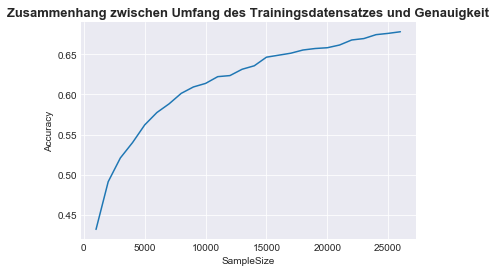

In [14]:
sample_acc_dict = {}

for size in range(1000,X_train.shape[0],1000):
    X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_train, y_train, train_size=size, random_state=0)
    lin_clf = LinearSVC(C=0.95)
    clf = lin_clf.fit(X_train_sample, y_train_sample)
    sample_acc_dict[size] = {}
    sample_acc_dict[size]["Test_Data_Accuracy"] = clf.score(X_test, y_test)
    
import pandas as pd

trainsize_df = pd.DataFrame.from_dict(sample_acc_dict,orient="index")

trainsize_df = trainsize_df.sort_index()
trainsize_df.reset_index(level=0, inplace=True)
trainsize_df.columns = ["SampleSize","Test_Data_Accuracy"]


import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("darkgrid")


plt.plot(trainsize_df["SampleSize"],trainsize_df["Test_Data_Accuracy"])
plt.title("Zusammenhang zwischen Umfang des Trainingsdatensatzes und Genauigkeit",weight="bold",size=13)
plt.xlabel("SampleSize")
plt.ylabel("Accuracy")



Wie sich zeigt würde das Modell von weiteren Trainingsbeispielen profitieren. Der Anstieg fällt mit zunehmender Trainingsgröße zwar schwächer aus, eine Hinzunahme von bspw. der 14. Wahlperiode (schätzungsweise ca. 9000 Reden) sollte dennoch eine um einige Prozentpunkte erhöhte Testgenauigkeit bedeuten.

### 3.2. Evaluation II - Test an Parteiprogrammen

Im zweiten Evaluationsschritt wird versucht, mit dem Modell Auszüge aus den Wahlprogrammen der Parteien von 2009 und 2013 zu klassifizieren.

In [15]:
lin_clf = LinearSVC(C=0.95)
clf = lin_clf.fit(training_data, corpus.target)

Zunächst wird das finale Modell anhand des gesamten Bundestagsreden-Datensatzes trainiert. Da ihm nun alle über 37.000 Reden als Trainingsdatensatz zur Verfügung stehen ist von einem etwas besseren Modell als noch im ersten Evaluationsschritt auszugehen. 

In [16]:
import csv

def get_testdata(file_name, testing_dict,max_sentence_count=10):
    path = "Testdata\\Manifesto Project\\"
    with open(path + file_name, encoding='utf-8') as read_file:
        party_name = file_name.split(".")[0].split("_")[0]
        if party_name == "CDU":
            party_name = "CDU_CSU"
        reader = csv.reader(read_file,delimiter=";")
        firstline = True
        text = []
        for row in reader:
            if firstline:
                firstline = False
                continue
            text.append(row)
        text_length = 0
        paragraph = ""
        for sentence in text:
            text_length += 1
            only_text = sentence[0][:-5].strip(",")
            only_text = only_text.replace("-","")
            only_text = only_text.lower()
            only_text = re.sub("[0-9]","",only_text)
            paragraph += only_text + " "
            if text_length == max_sentence_count:
                testing_dict["data"].append(paragraph)
                text_length = 0
                paragraph = ""
                testing_dict["label"].append(corpus.target_names.index(party_name))          
    return testing_dict

Die Wahlprogramme wurden über die Internetseite des Manifesto-Projects (https://manifestoproject.wzb.eu/) bezogen und als CSV-Dateien abgespeichert. Um sie analysefähig zu machen, wird eine Funktion erstellt, die diese Texte einliest und nach einer vorgegebenen Anzahl an Sätzen ("max-sentence_count") abtrennt. In dem nachfolgenden Test wird dieser Wert auf 20 festgelegt. Ein Testfall besteht also immer aus 20 zusammenhängenden Sätzen aus einem Wahlprogramm.

### 3.2.1. Wahlprogramme 2013

In [17]:
testing_dict = {"data":[],"label":[]}

test_data_manifesto_2013 = get_testdata("GRÜNE_2013.csv", testing_dict,20)
test_data_manifesto_2013 = get_testdata("CDU_2013.csv", test_data_manifesto_2013,20)
test_data_manifesto_2013 = get_testdata("DIE LINKE_2013.csv", test_data_manifesto_2013,20)
test_data_manifesto_2013 = get_testdata("FDP_2013.csv", test_data_manifesto_2013,20)
test_data_manifesto_2013 = get_testdata("SPD_2013.csv", test_data_manifesto_2013,20)

manifesto_testing_data_2013  = vectorizer.transform(test_data_manifesto_2013["data"])

In [18]:
test_data_manifesto_2013["data"][0]

'wir wollen sie bei der bundestagswahl am . september für eine andere, für eine bessere politik gewinnen. wir wenden uns mit unserem programm an alle, die meinen, dass wir in unserer gesellschaft jetzt einiges verändern müssen, um eine gute, eine sichere zukunft zu schaffen. wenn wir die klimakatastrophe so weit wie möglich aufhalten und die energiewende verwirklichen wenn wir morgen in einer gerechten und modernen gesellschaft leben wollen, dann können wir nicht abwarten – wir müssen heute politisch handeln. wir grüne haben immer versucht, politik zu machen, die über den tag hinausdenkt, seit der gründung der grünen in der bundesrepublik im jahr  und im osten seit / als grüne partei in der ddr und als bündnis . dabei waren wir mutig und ehrgeizig und manchmal haben wir uns dabei auch geirrt. aber aus unseren irrtümern haben wir gelernt, unser ehrgeiz hat uns stark gemacht und mit unserem mut haben wir die gesellschaft vorangebracht. wir wollten aus der atomkraft aussteigen, als noch a

So sieht der erste Wahlprogrammausschnitt aus.

In [19]:
print("Insgesamt enthält der Datensatz der 2013er Wahlprogramme {} Textausschnitte".format(len(test_data_manifesto_2013["data"])))

Insgesamt enthält der Datensatz der 2013er Wahlprogramme 859 Textausschnitte


In [20]:
clf.score(manifesto_testing_data_2013, test_data_manifesto_2013["label"])

0.6309662398137369

Das Modell erreicht eine Genauigkeit von 63% bei Auszügen aus den 2013er Wahlprogrammen. Da es sich um einen anderen Datensatz mit anderen Textarten handelt, als bei den ursprünglichen Trainingsdaten, ist mit einer gewissen Verschlechterung der Modellleistung zu rechnen. Die nach wie vor aktzeptable Leistung von etwas mehr als 63% spricht für eine gewisse Generalisierbarkeit des Modells auch fernab von Parlamentstexten.

In [21]:
from sklearn import metrics

predicted = clf.predict(manifesto_testing_data_2013)
print(metrics.classification_report(test_data_manifesto_2013["label"], predicted, target_names=corpus.target_names))

             precision    recall  f1-score   support

    CDU_CSU       0.62      0.78      0.69       149
  DIE LINKE       0.55      0.94      0.69       127
        FDP       0.82      0.48      0.60       151
      GRÜNE       0.80      0.49      0.61       283
        SPD       0.50      0.64      0.56       149

avg / total       0.68      0.63      0.63       859



In [22]:
metrics.confusion_matrix(test_data_manifesto_2013["label"], predicted)

array([[116,   4,   8,   6,  15],
       [  0, 119,   0,   2,   6],
       [ 48,   2,  72,   9,  20],
       [  8,  78,   3, 140,  54],
       [ 16,  15,   5,  18,  95]])

### 3.2.2. Wahlprogramme 2009

In [23]:
testing_dict = {"data":[],"label":[]}

test_data_manifesto_2009 = get_testdata("GRÜNE_2009.csv", testing_dict,20)
test_data_manifesto_2009 = get_testdata("CDU_2009.csv", test_data_manifesto_2009,20)
test_data_manifesto_2009 = get_testdata("DIE LINKE_2009.csv", test_data_manifesto_2009,20)
test_data_manifesto_2009 = get_testdata("FDP_2009.csv", test_data_manifesto_2009,20)
test_data_manifesto_2009 = get_testdata("SPD_2009.csv", test_data_manifesto_2009,20)

manifesto_testing_data_2009  = vectorizer.transform(test_data_manifesto_2009["data"])

In [24]:
print("Insgesamt enthält der Datensatz der 2009er Wahlprogramme {} Textausschnitte".format(len(test_data_manifesto_2009["data"])))

Insgesamt enthält der Datensatz der 2009er Wahlprogramme 601 Textausschnitte


In [25]:
clf.score(manifesto_testing_data_2009, test_data_manifesto_2009 ["label"])

0.6688851913477537

In [26]:
from sklearn import metrics

predicted = clf.predict(manifesto_testing_data_2009)
print(metrics.classification_report(test_data_manifesto_2009["label"], predicted, target_names=corpus.target_names))

             precision    recall  f1-score   support

    CDU_CSU       0.71      0.75      0.73       101
  DIE LINKE       0.50      0.94      0.65        85
        FDP       0.85      0.67      0.75       115
      GRÜNE       0.79      0.48      0.60       187
        SPD       0.61      0.70      0.65       113

avg / total       0.71      0.67      0.67       601



In [27]:
metrics.confusion_matrix(test_data_manifesto_2009["label"], predicted)

array([[76,  1,  7,  2, 15],
       [ 0, 80,  0,  3,  2],
       [19,  6, 77,  7,  6],
       [ 4, 64,  2, 90, 27],
       [ 8,  9,  5, 12, 79]])

Bei den 2009er Wahlprogrammen liegt das Modell sogar in 66,9% der Fälle richtig. Insgesamt ist das Modell bei den Wahlprogrammen nicht allzu weit von den Leistungen innerhalb des Bundestagsredendatensatzes entfernt, was als Zeichen für seine Generalisierbarkeit zu sehen ist. Bei genauerer Betrachtung der Ergebnisse zeigen sich folgende Auffälligkeiten:
* Wenn das Modell ein Dokument als zur Linkspartei zugehörig klassifiziert, liegt es insgesamt nur in etwas mehr als 50% der Fälle richtig. Eine Betrachtung der Konfusionsmatrixen zeigt, dass auch viele Grüne Wahlprogrammstellen der Linken zugeordnet wurden. Möglicherweise wirkt sich hier aus, dass von der Linken nur Reden aus der Oppositionsrolle zur Verfügung stehen, weswegen das Modell vermutlich kritische Sprache hauptsächlich als Linke Texte identifiziert.
* Aus dem ersten Punkt ergibt sich das Problem, dass das Modell weniger als 50% der Grünen Textpassagen findet.
* Während die 2009er FDP Passagen gut von dem Modell klassifiziert werden, versieht es bei den 2013er Stellen fast die Hälfte der FDP Texte mit CDU/CSU-Labeln. Möglicherweise sagt das auch etwas über die Veränderung des FDP-Wahlprogramms aus, das sich 2013 politisch näher an die CDU/CSU angelehnt haben könnte. In erster Linie wird es jedoch dem Umstand geschuldet sein, dass aus der aktuellen Wahlperiode keine FDP-Reden zur Verfügung stehen.

### 3.2.3 Zusammenhang zwischen Textlänge und Genauigkeit

Zum Abschluss wird noch betrachtet, wie sehr die Genauigkeit der Vorhersagen mit der Länge der einzelnen Wahlprogrammausschnitte zusammenhängt. Der zuvor relativ willkürlich auf 20 Sätze pro Wahlprogrammausschnitt festgelegte Wert sollte eine Rolle dabei spielen, wie gut das Modell die Texte zuordnen kann. 

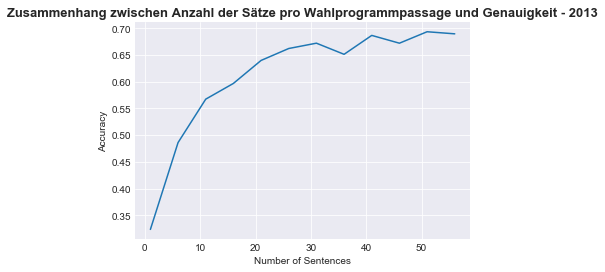

In [28]:
test_size_dict = {"number_of_sentence": [],"accuracy":[]}


for sentence_number in range(1,60,5):
    testing_dict = {"data":[],"label":[]}
    test_data_manifesto_2013 = get_testdata("GRÜNE_2013.csv", testing_dict,sentence_number)
    test_data_manifesto_2013 = get_testdata("CDU_2013.csv", test_data_manifesto_2013,sentence_number)
    test_data_manifesto_2013 = get_testdata("DIE LINKE_2013.csv", test_data_manifesto_2013,sentence_number)
    test_data_manifesto_2013 = get_testdata("FDP_2013.csv", test_data_manifesto_2013,sentence_number)
    test_data_manifesto_2013 = get_testdata("SPD_2013.csv", test_data_manifesto_2013,sentence_number)
    manifesto_testing_data_2013  = vectorizer.transform(test_data_manifesto_2013["data"])
    test_size_dict["number_of_sentence"].append(sentence_number)
    accuracy = clf.score(manifesto_testing_data_2013, test_data_manifesto_2013["label"])
    test_size_dict["accuracy"].append(accuracy)

import pandas as pd

trainsize_df = pd.DataFrame.from_dict(test_size_dict ,orient="columns")
trainsize_df.columns = ["Manifesto2013_Accuracy","Number_of_Sentences"]



import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("darkgrid")


plt.plot(trainsize_df["Number_of_Sentences"],trainsize_df["Manifesto2013_Accuracy"])
plt.title("Zusammenhang zwischen Anzahl der Sätze pro Wahlprogrammpassage und Genauigkeit - 2013",weight="bold",size=13)
plt.xlabel("Number of Sentences")
plt.ylabel("Accuracy")

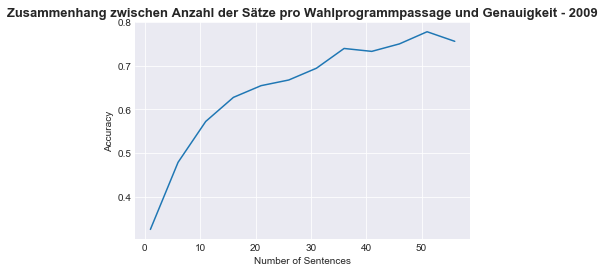

In [29]:
test_size_dict = {"number_of_sentence": [],"accuracy":[]}


for sentence_number in range(1,60,5):
    testing_dict = {"data":[],"label":[]}
    test_data_manifesto_2009 = get_testdata("GRÜNE_2009.csv", testing_dict,sentence_number)
    test_data_manifesto_2009 = get_testdata("CDU_2009.csv", test_data_manifesto_2009,sentence_number)
    test_data_manifesto_2009 = get_testdata("DIE LINKE_2009.csv", test_data_manifesto_2009,sentence_number)
    test_data_manifesto_2009 = get_testdata("FDP_2009.csv", test_data_manifesto_2009,sentence_number)
    test_data_manifesto_2009 = get_testdata("SPD_2009.csv", test_data_manifesto_2009,sentence_number)
    manifesto_testing_data_2009  = vectorizer.transform(test_data_manifesto_2009["data"])
    test_size_dict["number_of_sentence"].append(sentence_number)
    accuracy = clf.score(manifesto_testing_data_2009, test_data_manifesto_2009["label"])
    test_size_dict["accuracy"].append(accuracy)

import pandas as pd

trainsize_df = pd.DataFrame.from_dict(test_size_dict ,orient="columns")
trainsize_df.columns = ["Manifesto2009_Accuracy","Number_of_Sentences"]

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("darkgrid")


plt.plot(trainsize_df["Number_of_Sentences"],trainsize_df["Manifesto2009_Accuracy"])
plt.title("Zusammenhang zwischen Anzahl der Sätze pro Wahlprogrammpassage und Genauigkeit - 2009",weight="bold",size=13)
plt.xlabel("Number of Sentences")
plt.ylabel("Accuracy")

Es zeigt sich, dass das Modell mit zunehmender Länge die Textpassagen besser klassifizieren kann. Sobald ein Wert von 40 Sätzen oder mehr für die Wahlprogrammausschnitte gewählt wurde, erreicht das Modell in den 2013er Wahlprogrammen die Genauigkeit, die es auch in den Tests mit den Bundestagsreden gezeigt hat. Bei den 2009er Wahlprogrammen übertrifft es diese dann sogar, und erreicht einen Wert deutlich über 70%. Das ist insoweit einleuchtend, als dass mit größerem Textumfang auch eine größere Chance besteht, zur politischen Klassifikation relevante Wörter im Text zu finden. 

Damit lässt sich festhalten, dass das Modell bei den Tests an den Textausschnitten aus den Wahlprogrammen nicht schlechter abschneidet, als bei den Bundestagsreden, so lange ein ausreichend langer Text zur Verfügung steht. Das ist bemerkenswert, da es sich um andere Textarten handelt, bei denen unterstellt werden kann, dass sie einer gewissen anderen sprachlichen Logik folgen (allgemeineres politisches Vokabular), als einzelne Bundestagsreden (themenspezifisches Fachvokabular). Ein Beleg für die Generalisierbarkeit des Modells abseits von Parlamentsreden und der Regierungs/-Oppositionsdimension.

### 3.3. Evaluation III - Test anhand von  Zeitungskolumnen

Als dritter Evaluationsschritt wird sich von den direkt parteipolitischen Texten gelöst und die Anwendbarkeit des Modells auf Artikel in Medien getestet. Das hier dargelegte Vorgehen ist nur als erster Versuch zu sehen, für wirkliche Leistungseinschätzungen ist ein anderer Korpus an Artikeln notwendig, der sowohl wesentlich umfangreicher, als auch systematischer nach Parteinähe aufgebaut sein muss. Für eine erste Idee und um einen möglichen Anwendungsfall des Modells zu demonstrieren wurde es testweise auf 10 relativ aktuelle politische Kolumnenartikel aus Spiegel und FAZ angewendet.

In [30]:
from sklearn.calibration import CalibratedClassifierCV

lin_clf = LinearSVC(C=0.95)
lin_clf = CalibratedClassifierCV(lin_clf) 
clf = lin_clf.fit(training_data, corpus.target)

Das CalibratedClassifierCV Objekt ermöglicht dem Modell probalistische Vorhersagen zu treffen. Dadurch wird im Anwendungsfall klarer, für wie wahrscheinlich bzw. eindeutig das Modell eine politische Einordnung hält und ob es einen Text vielleicht sogar mehreren Parteirichtungen mit ähnlicher Wahrscheinlichkeit zuordnet. Ohne diese Information steht ausschließlich eine eindeutige Parteizuordnung als absolute Aussage für sich, selbst wenn andere Parteien möglicherweise fast genauso wahrscheinliche Klassifizierungen sind. Da gerade bei medialen Texten auch davon auszugehen ist, dass sie sich aus einer Verbindung mehrerer parteipolitischen Ideologien ergeben, erscheint dies wesentlich aussagekräftiger. 

In [31]:
import os

path = "Testdata\\News_Article\\"

def load_txt_files(path):
    file_list = []
    name_list = []
    for file in os.listdir(path):
        text = open(path + file, encoding="utf-8").read()
        text = re.sub("[0-9]","",text)
        text = re.sub("[,.'!?;–:—\"„“”)(]","",text)
        text = re.sub("\n"," ",text)
        file_list.append(text)
        name_list.append(file.split("_")[1] + "_" + file.split("_")[2] + "_" + file.split("_")[3].replace(".txt",""))
    return {"data": file_list, "label": name_list}


dict_data = load_txt_files(path)   

Die als Textdatei vorliegende Kolumnen werden in einem Dictionary abgespeichert und mit dem Zeitungsnamen, dem Autor und dem Datum gelabelt.

In [32]:
news_testing_data  = vectorizer.transform(dict_data["data"])

Mittels des tf-idf-vectorizers der Bundestagsreden werden die Texte in eine Document-Frequency-Matrix transformiert, die genauso aufgebaut ist, wie der ursprüngliche Trainingsdatensatz.

In [33]:
pred_prob_list = [(corpus.target_names[list(prediction).index(max(prediction))],max(prediction)) for prediction in clf.predict_proba(news_testing_data)]
for index,article in enumerate(dict_data["label"]):
    print("Artikel: {} , Prediction: {} , Probability: {:.2f}".format(article, pred_prob_list[index][0],pred_prob_list[index][1] ))
    

Artikel: FAZ_Altenbockum_02.05.2017 , Prediction: CDU_CSU , Probability: 0.44
Artikel: FAZ_Altenbockum_25.05.2017 , Prediction: GRÜNE , Probability: 0.58
Artikel: Spiegel_Fricke_16.06.2017 , Prediction: GRÜNE , Probability: 0.38
Artikel: Spiegel_Augstein_19.06.2017 , Prediction: DIE LINKE , Probability: 0.66
Artikel: FAZ_Altenbockum_12.06.2017 , Prediction: CDU_CSU , Probability: 0.81
Artikel: Spiegel_Stokowski_13.06.2017 , Prediction: DIE LINKE , Probability: 0.55
Artikel: Spiegel_Lobo_14.06.2017 , Prediction: SPD , Probability: 0.41
Artikel: Spiegel_Stücker_18.06.2017 , Prediction: DIE LINKE , Probability: 0.50
Artikel: FAZ_Altenbockum_09.05.2017 , Prediction: CDU_CSU , Probability: 0.50
Artikel: Spiegel_Fleischhauer_15.06.2017 , Prediction: SPD , Probability: 0.45


Das Modell ordnet drei der vier FAZ-Artikel als am ehsten der CDU/CSU zugehörig ein. Die sechs Spiegel Artikel werden drei mal der Linkspartei zugeordnet,einmal den Grünen und zweimal der SPD. Intuitiv erscheint diese Einordnung relativ nachvollziehbar. Eine wirkliche Evaluation bieten diese Ergebnisse jedoch, wie angesprochen, nicht.

### 3.4. Abschluss - Einordnung der Eingangszitate

Zum Abschluss wird das Modell nach der politischen Richtung der beiden in der Einleitung erwähnten Zitate zur Atom-/Kernkraft befragt. Wie bei den Wahlprogrammen gesehen steigt die Genauigkeit des Modells mit der Länge des Textes, insoweit ist nicht zu viel bei der Anwendung auf so kurze Texte zu erwarten. Gleichzeitig symbolisieren beide Zitate verdichtete, klar abgrenzbare politische Positionen, was eine richtige Einordnung nicht unmöglich erscheinen lässt. 

In [34]:
intro_strings = ["Im Licht des CO2-Problems ist die Kernkraft eine saubere, unter Sicherheitsaspekten verantwortbare Energie und auch für die Zukunft wichtig.",
                 "Atomkraft ist längst zur Bremse für den Klimaschutz geworden. Ein Festhalten an der Atomenergie hieße, die Brücke hin zu einer sicheren, klimaverträglichen Energieversorgung abzureißen."] 

In [35]:
intro_string_testing_data  = vectorizer.transform(intro_strings)

In [36]:
pred_prob_list = [(corpus.target_names[list(prediction).index(max(prediction))],max(prediction)) for prediction in clf.predict_proba(intro_string_testing_data)]
for index in range(2):
    print("Zitat: {} , Prediction: {} , Probability: {:.2f}".format(index, pred_prob_list[index][0],pred_prob_list[index][1] ))
    

Zitat: 0 , Prediction: FDP , Probability: 0.60
Zitat: 1 , Prediction: GRÜNE , Probability: 0.67


Dem Modell gelingt die Einordnung beider Zitate trotz der kurzen Texte überraschend gut. Das Zitat von Jürgen Trittin spricht es richtigerweise den Grünen zu. Bei dem Zitat von Angela Merkel liegt es zwar mit der Partei daneben, jedoch stimmt die politische Richtung: CDU und FDP vertraten beide die gleiche Position hinsichtlich Atom-/Kernkraft. Dementsprechend würde es auch einem menschlichen Tester nicht leicht fallen, das erste Zitat sicher der CDU und nicht der FDP zuzusprechen. 

## 4. Fazit

Das trainierte Modell erreicht über mehrere Legislaturperioden (15.-18.) mit wechselnden Regierungs- und Oppositionskonstellationen eine Genauigkeit von 70% innerhalb des Reden-Datensatzes und bei einer ausreichenden Länge der Texte auch eine vergleichbare Genauigkeit bei der Anwendung auf die Wahlprogramme der Parteien. Daraus lässt sich schließen, dass es die Probleme der bisherigen Versuche zur Klassifikation von politischer Ideologie zumindest zum Teil löst und eine gewisse Generalisierbarkeit fernab von Regierungs- und Oppositionssprache erreicht. An einer Reihe von Punkten muss noch gearbeitet werden, bevor eine verlässliche Anwendung des Modells möglich scheint:
* Um die Reichweite und das Leistungsvermögen des Modells abseits von direkter Sprache von Politikern wirklich einschätzen zu können, ist  ein dritter Evaluationsschritt notwendig. Eine Test-Korpus von Artikeln aus parteinahen bzw. Partei-Zeitungen und Stiftungen würde eine bessere Einschätzung der Anwendbarkeit des Modells auf journalistische Texte bieten.
* Das festgestellte Problem der schwierigen Unterscheidung zwischen Linkspartei und Grünen Reden, mutmaßlich verursacht durch die reine Oppositionsrolle der Linken, könnte durch die Hinzunahme von Landtagsreden, bei denen die Linkspartei die Rolle der Regierung einnimmt, verbessert bzw. abgeschwächt werden.
* Die Aufnahme von Landtagsreden würde gleichzeitig die Integration von AfD-Reden in das Modell ermöglichen und so auch das rechte politische Spektrum abbilden.  
* Insgesamt profitiert das Modell von einem größeren Umfang des Trainingsdatensatzes. Bei einer Erweiterung des Trainings-Korpus auf die 14. Wahlperiode (dessen Protokolle als PDF-Dateien zur Verfügung stehen) ständen nicht nur generell wesentlich mehr Trainingsbeispiele zur Verfügung. Dadurch dass die FDP in diesem Bundestag vertreten war, könnte die Leistung des Modells in diesem Bereich besonders verbessert werden.
* Die Größe des Datensatzes könnte potentiell ausreichend sein für komplexere Deep Learning Modelle. Möglicherweise kann auch dadurch die Genauigkeit weiter verbessert werden

Eine genaue Bewertung und Einordnung der Leistungsfähigkeit eines solchen Modells bleibt immer schwierig, solange nicht bekannt ist, wie gut Menschen Texte politisch einordnen könnten. Interessant wäre ein direkter Vergleich zu Laien- und Experten-Klassifikationen zu den gleichen, von stopwords befreiten Texten.
